# <header>**Baseline model for Automated Essay Scoring competition**</header>

*Version 0.1*

In [1]:
!pip install torchview
!pip install torchinfo

# Utils

In [2]:
import random
from kaggle_secrets import UserSecretsClient
import wandb
import os
import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchview import draw_graph
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import LongformerModel, LongformerTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_ha")

wandb.login(key=wandb_api)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

cuda


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
model_path = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_path)
embedder = LongformerModel.from_pretrained(model_path, attention_window=128)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
ling_features = ['num_paragraphs', 'num_words', 'num_conjunctions',
                 'num_distinct_words', 'num_misspell',
                 'mean_word_len', 'num_sentences', 'mean_sent_len']

In [5]:
data_dir = "/kaggle/input/aes-linguistic"
# data_dir = "../../output/"
train_data = pd.read_csv(os.path.join(data_dir, 'train_linguistic.csv'))
extra_data = pd.read_csv(os.path.join(data_dir, 'extra_linguistic.csv'))

extra_data = extra_data[~extra_data['full_text'].isna()]
train_data = train_data[~train_data['full_text'].isna()]

train_data = train_data[['essay_id', 'full_text', 'score'] + ling_features]
extra_data = extra_data[['essay_id', 'full_text', 'score'] + ling_features]

extra_data = extra_data[~extra_data['full_text'].isin(train_data['full_text'])]

print(train_data.shape, extra_data.shape)

train_data.sample(5)

(17307, 11) (13123, 11)


,essay_id,full_text,score,num_paragraphs,num_words,num_conjunctions,num_distinct_words,num_misspell,mean_word_len,num_sentences,mean_sent_len
12696,bb4c434,"People tend to use there cars so much, they ba...",3,8,606,26,208,20,3.905263,26,23.307692
4625,44e88b0,Imagine being a top scientist at NASA and Viki...,3,5,427,10,178,8,4.342391,22,19.409091
733,0ba78ec,The face of Mars could not be created by alien...,3,3,241,9,112,5,4.267857,12,20.083333
16885,f96c287,Many people belive that the face on Mars was c...,3,5,273,6,161,18,4.213115,14,19.500000
3334,317173f,Driverless Cars are coming soon or later? Peop...,4,6,643,39,165,8,4.028099,31,20.741935


Split train, val, test set

In [6]:
all_data = pd.concat([train_data, extra_data], ignore_index=True)
# shuffle the data
all_data = all_data.sample(frac=1, random_state=random_seed)
all_data = all_data.reset_index(drop=True)

train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

train_df, val_df = train_test_split(all_data, test_size=val_ratio + test_ratio, 
                                    random_state=random_seed)
val_df, test_df = train_test_split(val_df, test_size=test_ratio/(val_ratio + test_ratio), 
                                   random_state=random_seed)

print(train_df.shape, val_df.shape, test_df.shape)

(21301, 11) (4564, 11) (4565, 11)


Hyperparameters

In [7]:
hyperparameters = {
    'lr': 5e-5,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'train_set': {
        'total': len(train_df),
        'ratio': train_ratio,
    },
    'val_set': {
        'total': len(val_df),
        'ratio': val_ratio,
    },
    'test_set': {
        'total': len(test_df),
    },
    'linguistic_features': ling_features,
    'accelator': str(device)
}

In [8]:
train_tokenized = tokenizer(train_df['full_text'].tolist(),
                            padding=True, 
                            return_tensors="np")

hyperparameters['max_seq_len'] = train_tokenized['input_ids'].shape[1]

train_df['input_ids'] = train_tokenized['input_ids'].tolist()
train_df['attention_mask'] = train_tokenized['attention_mask'].tolist()


print(len(train_df.sample(1).iloc[0]['input_ids']))

1916


In [9]:
val_tokenized = tokenizer(val_df['full_text'].tolist(),
                          max_length=hyperparameters['max_seq_len'],
                          padding='max_length', truncation=True, 
                          return_tensors="np")

val_df['input_ids'] = val_tokenized['input_ids'].tolist()
val_df['attention_mask'] = val_tokenized['attention_mask'].tolist()


print(len(val_df.sample(1).iloc[0]['input_ids']))

1916


In [10]:
test_tokenized = tokenizer(test_df['full_text'].tolist(),
                           max_length=hyperparameters['max_seq_len'], 
                           padding='max_length', truncation=True, 
                           return_tensors="np")

test_df['input_ids'] = test_tokenized['input_ids'].tolist()
test_df['attention_mask'] = test_tokenized['attention_mask'].tolist()

print(len(test_df.sample(1).iloc[0]['input_ids']))

1916


In [11]:
class MultiFeaturesDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.token_ids = df['input_ids'].values
        self.attention_mask = df['attention_mask'].values
        self.score = df['score'].values
        self.ling_features = []
        for feature in ling_features:
            self.ling_features.append(df[feature].values)

    def __len__(self):
        return len(self.score)

    def __getitem__(self, idx):
        features = []
        for feature in self.ling_features:
            features.append(feature[idx])

        features = torch.tensor(features, dtype=torch.float)

        score = torch.reshape(torch.tensor(
            self.score[idx], dtype=torch.float), (1,))

        return torch.tensor(self.token_ids[idx]), torch.tensor(self.attention_mask[idx]), features, score


train_dataset = MultiFeaturesDataset(train_df)
val_dataset = MultiFeaturesDataset(val_df)

In [12]:
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

for token_ids, attention_mask, features, score in train_dataloader:
    print(token_ids.shape, attention_mask.shape, features.shape, score.shape)
    break

torch.Size([64, 1916]) torch.Size([64, 1916]) torch.Size([64, 8]) torch.Size([64, 1])


In [13]:
class MultiFeaturesModel(torch.nn.Module):
    def __init__(self, embedder,
                 lf_input_size, lf_hidden_size=64,
                 dropout=0.2):
        super(MultiFeaturesModel, self).__init__()
        # freeze
        # for param in embedder.parameters():
        #     param.requires_grad = False
            
        self.embedder = embedder
        self.lf = torch.nn.Linear(lf_input_size,lf_hidden_size)
        self.fc = torch.nn.Linear(lf_hidden_size + embedder.config.hidden_size, 256)
        self.regressor = torch.nn.Linear(256, 1)
        self.dropout = torch.nn.Dropout(dropout)
    
    def config(self):
        return {
            'embedder': self.embedder.config,
            'lf': {
                'input_size': self.lf.in_features,
                'hidden_size': self.lf.out_features
            },
            'fc': {
                'input_size': self.fc.in_features,
                'hidden_size': self.fc.out_features
            },
            'regressor': {
                'input_size': self.regressor.in_features,
                'output_size': self.regressor.out_features
            }
        }

    def forward(self, token_ids, attention_mask, ling_features):
        embedded = self.embedder(token_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        if self.training:
            embedded = self.dropout(embedded)
            
        ling_features = F.leaky_relu(self.lf(ling_features))
        if self.training:
            ling_features = self.dropout(ling_features)
            
        features = torch.cat((embedded, ling_features), dim=1)
        features = F.leaky_relu(self.fc(features))
        if self.training:
            features = self.dropout(features)
            
        score = self.regressor(features)
        return score


model = MultiFeaturesModel(embedder, len(ling_features),
                           128,
                           hyperparameters['dropout'])

inputs = next(iter(train_dataloader))[:-1]
model_summary = summary(model, input_data=inputs)

model_summary

Input ids are automatically padded from 1916 to 1920 to be a multiple of `config.attention_window`: 128


Layer (type:depth-idx)                                       Output Shape              Param #
MultiFeaturesModel                                           [64, 1]                   --
├─LongformerModel: 1-1                                       [64, 768]                 --
│    └─LongformerEmbeddings: 2-1                             [64, 1920, 768]           --
│    │    └─Embedding: 3-1                                   [64, 1920, 768]           (38,603,520)
│    │    └─Embedding: 3-2                                   [64, 1920, 768]           (3,147,264)
│    │    └─Embedding: 3-3                                   [64, 1920, 768]           (768)
│    │    └─LayerNorm: 3-4                                   [64, 1920, 768]           (1,536)
│    │    └─Dropout: 3-5                                     [64, 1920, 768]           --
│    └─LongformerEncoder: 2-2                                [64, 1916, 768]           --
│    │    └─ModuleList: 3-6                                  --     

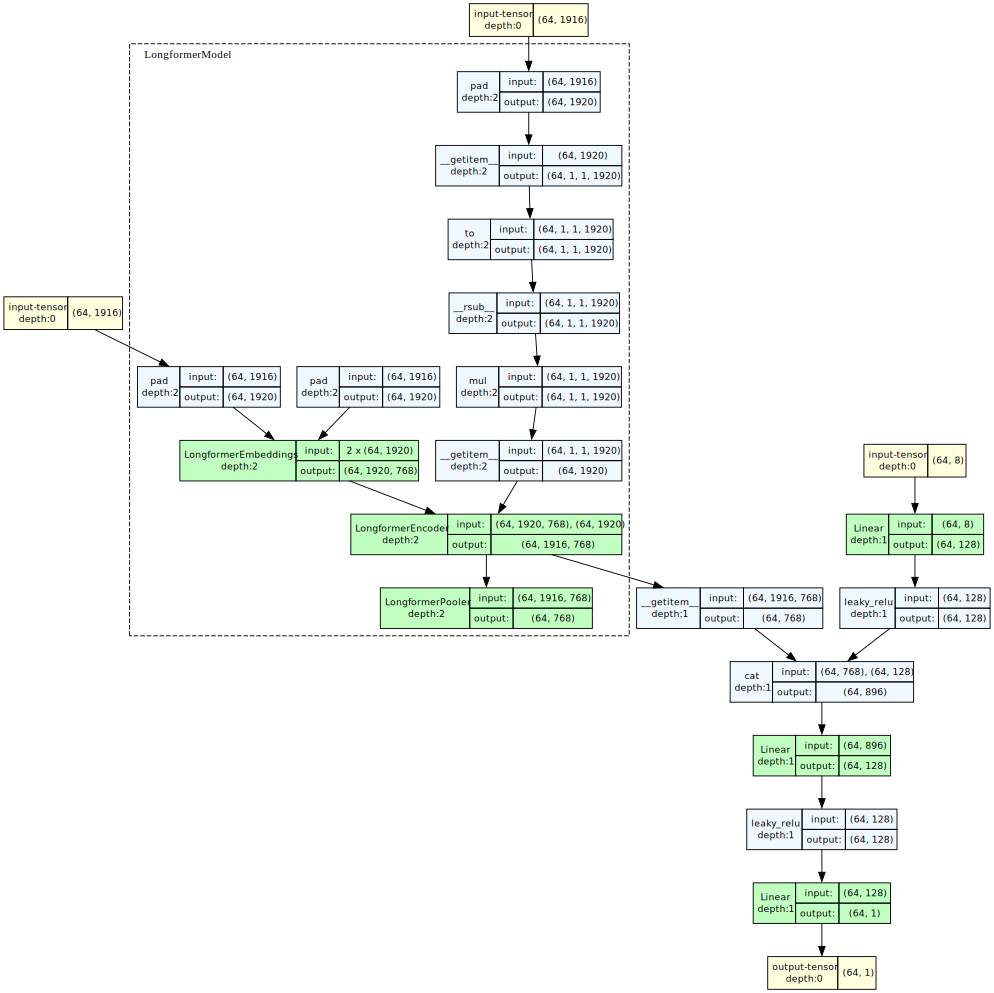

In [14]:
model_graph = draw_graph(model,
                         input_data=inputs,
                         expand_nested=True,
                         depth=2)
model_graph.visual_graph

In [15]:
def train(model, optimizer, criterion, train_dataloader, logging_steps=20):
    model.train()
    running_loss = 0.0

    for i, (token_ids, attention_mask, features, score) in enumerate(train_dataloader):

        output = model(token_ids.to(device),
                       attention_mask.to(device),
                       features.to(device))
        loss = criterion(output, score.to(device)).float()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

        if (i + 1) % (logging_steps) == 0 or (i + 1) == len(train_dataloader):
            wandb.log({'train_loss_steps': running_loss / (i + 1),
                       'learning_rate': optimizer.param_groups[0]['lr']})

    return running_loss / len(train_dataloader)


def evaluate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    all_scores = []
    predictions = []

    with torch.no_grad():
        for token_ids, attention_mask, features, score in dataloader:
            output = model(token_ids.to(device),
                           attention_mask.to(device),
                           features.to(device))

            loss = criterion(output, score.to(device)).float()

            running_loss += loss.item()
            all_scores.extend(score.cpu().numpy())
            predictions.extend(output.cpu().numpy())

    return running_loss / len(dataloader), torch.tensor(all_scores), torch.tensor(predictions)

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
def logit_to_score(logit, min_score=1, max_score=6):
    scores = torch.clamp(torch.round(logit), min_score, max_score)
    scores = scores.long()
    return scores


class WeightedKappaLoss(torch.nn.Module):
    def __init__(
        self, num_classes: int, weights: str = "quadratic", epsilon: float = 1e-6,
    ) -> None:
        super().__init__()
        label_vec = torch.arange(0, num_classes).float()
        self.row_label_vec = label_vec.view(1, num_classes)
        self.col_label_vec = label_vec.view(num_classes, 1)
        row_mat = torch.tile(self.row_label_vec, (num_classes, 1))
        col_mat = torch.tile(self.col_label_vec, (1, num_classes))
        if weights == 'quadratic':
            self.ops = torch.square
        elif weights == 'linear':
            self.ops = torch.abs
        else:
            raise ValueError()
        self.num_classes = num_classes
        self.weight_mat = self.ops(col_mat - row_mat)
        self.epsilon = epsilon

    def forward(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
        bs = y_true.size(0)
        y_true = F.one_hot(y_true, self.num_classes)
        y_true = y_true.to(device=y_pred.device, dtype=y_pred.dtype)
        col_label_vec = self.col_label_vec.clone().to(y_pred.device)
        row_label_vec = self.row_label_vec.clone().to(y_pred.device)
        weight_mat = self.weight_mat.clone().to(y_pred.device)
        cat_labels = torch.matmul(y_true, col_label_vec)
        cat_label_mat = torch.tile(cat_labels, (1, self.num_classes))
        row_label_mat = torch.tile(row_label_vec, (bs, 1))
        weight = self.ops(cat_label_mat - row_label_mat)
        numerator = torch.sum(weight * y_pred)
        label_dist = torch.sum(y_true, dim=0, keepdim=True)
        pred_dist = torch.sum(y_pred, dim=0, keepdim=True)
        w_pred_dist = torch.matmul(weight_mat, pred_dist.T)
        dominator = torch.sum(torch.matmul(label_dist, w_pred_dist)) / bs
        loss = torch.log(numerator / dominator + self.epsilon)
        return loss


qwk_loss = WeightedKappaLoss(num_classes=6)


def hybrid_loss(y_pred, y_true):
    mse_loss = F.mse_loss(y_pred, y_true)

    y_pred_onehot = logit_to_score(y_pred) - 1
    y_pred_onehot = y_pred_onehot.long().squeeze(-1)
    y_pred_onehot = F.one_hot(y_pred_onehot, num_classes=6).float()
    y_true = y_true - 1

    kappa_loss = qwk_loss(y_true.long(), y_pred_onehot)

    return mse_loss + kappa_loss

In [18]:
criterion = hybrid_loss
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyperparameters['lr'],
                              weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
early_stopper = EarlyStopper(patience=2, min_delta=1e-4)

train_losses, val_losses, val_kappa_scores = [], [], []

hyperparameters['early_stopper'] = early_stopper.__dict__['patience']
hyperparameters['scheduler'] = scheduler.__dict__
hyperparameters['model'] = model.config()

hyperparameters

{'lr': 0.0001,
 'dropout': 0.2,
 'epochs': 10,
 'batch_size': 64,
 'train_set': {'total': 21301, 'ratio': 0.7},
 'val_set': {'total': 4564, 'ratio': 0.15},
 'test_set': {'total': 4565},
 'linguistic_features': ['num_paragraphs',
  'num_words',
  'num_conjunctions',
  'num_distinct_words',
  'num_misspell',
  'mean_word_len',
  'num_sentences',
  'mean_sent_len'],
 'accelator': 'cuda',
 'max_seq_len': 1916,
 'early_stopper': 2,
 'scheduler': {'factor': 0.5,
  'optimizer': AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: None
      lr: 0.0001
      maximize: False
      weight_decay: 0.01
  ),
  'min_lrs': [0],
  'patience': 5,
  'verbose': False,
  'cooldown': 0,
  'cooldown_counter': 0,
  'mode': 'min',
  'threshold': 0.0001,
  'threshold_mode': 'rel',
  'best': inf,
  'num_bad_epochs': 0,
  'mode_worse': inf,
  'eps': 1e-08,
  'last_epoch': 0},
 'model': {'em

In [19]:
torch.cuda.empty_cache()
model.to(device)

wandb.init(project='deep-essay-scoring', config=hyperparameters)

for epoch in range(hyperparameters['epochs']):
    train_loss = train(model, optimizer, criterion, train_dataloader)
    train_losses.append(train_loss)

    val_loss, val_scores, val_predictions = evaluate(
        model, criterion, val_dataloader)
    val_kappa = cohen_kappa_score(val_scores.cpu().numpy(),
                                  logit_to_score(
                                      val_predictions).cpu().numpy(),
                                  weights='quadratic')

    val_losses.append(val_loss)
    val_kappa_scores.append(val_kappa)

    scheduler.step(val_loss)

    wandb.log({'train_loss': train_loss, 'val_loss': val_loss,
              'val_kappa': val_kappa, 'epoch': epoch+1})

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Kappa: {val_kappa}')

#     if early_stopper.early_stop(val_losses[-1]):
#         print("Early stopping")
#         break

wandb: Currently logged in as: minha-lehoang. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240504_150827-pd2nh5dp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run civilized-republic-29
wandb: ⭐️ View project at https://wandb.ai/minha-lehoang/deep-essay-scoring
wandb: 🚀 View run at https://wandb.ai/minha-lehoang/deep-essay-scoring/runs/pd2nh5dp
/tmp/ipykernel_24/2490093398.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  return running_loss / len(dataloader), torch.tensor(all_scores), torch.tensor(predictions)


Epoch: 1, Train Loss: 14.017032992732418, Val Loss: 5.037096341451009, Val Kappa: 0.5876552262645701
Epoch: 2, Train Loss: 6.385643550941536, Val Loss: 6.214463969071706, Val Kappa: 0.37940461792157265
Epoch: 3, Train Loss: 5.5179523576845275, Val Loss: 5.790786776277754, Val Kappa: 0.4290980593187511
Epoch: 4, Train Loss: 5.20407625433203, Val Loss: 5.443977508280012, Val Kappa: 0.4756756528208458
Epoch: 5, Train Loss: 5.061628844286944, Val Loss: 5.292465024524265, Val Kappa: 0.5173781462205895
Epoch: 6, Train Loss: 4.991466947503992, Val Loss: 5.052765455510881, Val Kappa: 0.5902873839152813
Epoch: 7, Train Loss: 4.956180800188769, Val Loss: 4.974730425410801, Val Kappa: 0.609789470477458
Epoch: 8, Train Loss: 4.900034726918997, Val Loss: 4.86578388677703, Val Kappa: 0.6482435414960124
Epoch: 9, Train Loss: 4.866297192043728, Val Loss: 4.905710253450605, Val Kappa: 0.632336031624176
Epoch: 10, Train Loss: 4.849183512163592, Val Loss: 4.814162373542786, Val Kappa: 0.667725961548453


In [20]:
# Get current date and time
now = datetime.datetime.now()
now_str = now.strftime("%YY-%mm-%dd") 

embedder_name = model_path.split('/')[-1]
model_name = f'multi_features_{embedder_name}_{now_str}_model'

# Save the model
with open(f'{model_name}_summary.text', 'w') as f:
    f.write(str(model_summary))

torch.save(model.state_dict(), f'{model_name}.pth')

In [21]:
torch.cuda.empty_cache()

In [22]:
model.eval()
test_predictions = []

with torch.no_grad():
    for i, row in test_df.iterrows():
        token_ids = torch.tensor(row['input_ids']).unsqueeze(0)
        attention_mask = torch.tensor(row['attention_mask']).unsqueeze(0)
        row_ling_features = torch.tensor(row[ling_features].tolist()).unsqueeze(0)

        output = model(token_ids.to(device), 
                       attention_mask.to(device), 
                       row_ling_features.to(device))
        test_predictions.append(output.item())
        
submit_df = pd.DataFrame({
    'essay_id': test_df['essay_id'],
    'prediction': logit_to_score(torch.tensor(test_predictions)).cpu().numpy()
})
print(submit_df.shape)
submit_df.to_csv('submission.csv', index=False)

(4565, 2)
